# (25) Fix Cfg, Copy fits

**Motivation**: Added Res Eps to all Cfg files, copied saved trainers back to models_copied folder for a new fit. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Copy models over

In [2]:
path_models_copied = '/home/hadi/Documents/MTVAE/models_copied'

In [3]:
for x in sorted(os.listdir(results_dir())):
    category, nf, beta, model = extract_info(x)
    if not (category == 'fixate1' and nf == 420):
        continue
    
    path_src = pjoin(results_dir(), x, 'Trainer')
    
    path_model = pjoin(path_models_copied, x)
    os.makedirs(path_model, exist_ok=False)

    path_fit = pjoin(path_model, 'fit_main')
    os.makedirs(path_fit, exist_ok=False)

    for file in os.listdir(path_src):
        if '.pt' in file or 'Train' in file:
            path_dst = path_fit
        else:
            path_dst = path_model
        shutil.copy(
            src=pjoin(path_src, file),
            dst=pjoin(path_dst, file),
        )

## Verify if successful

In [5]:
path = 'Documents/MTVAE/models_copied'

model_name = 'fixate1_nf-420_beta-0.15_(2023_04_27,20:20)'
fit_name = 'fit_main'

tr, meta = load_model(
    model_name=model_name,
    fit_name=fit_name,
    device='cuda:2',
    verbose=True,
    path=path,
)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  23.3 Mil  |
|     ---      |    ---     |
|     stem     |    320     |
| pre_process  |  151.6 K   |
|  enc_tower   |  11.5 Mil  |
|     enc0     |   66.0 K   |
| enc_sampler  |  2.6 Mil   |
| dec_sampler  |  2.5 Mil   |
|    expand    |  351.2 K   |
|  dec_tower   |  6.0 Mil   |
| post_process |   67.9 K   |
|     out      |    578     |
+--------------+------------+

# params: 23.3 M

In [6]:
tr.model.cfg.res_eps

1.0

In [8]:
%%time

data, loss = tr.validate()

CPU times: user 1min 52s, sys: 59.3 s, total: 2min 51s
Wall time: 5min


In [9]:
{k: v.mean() for k, v in loss.items()}

{'epe': 1.7706264, 'kl': 37.097996, 'kl_diag': 0.08832856}

fig/sample

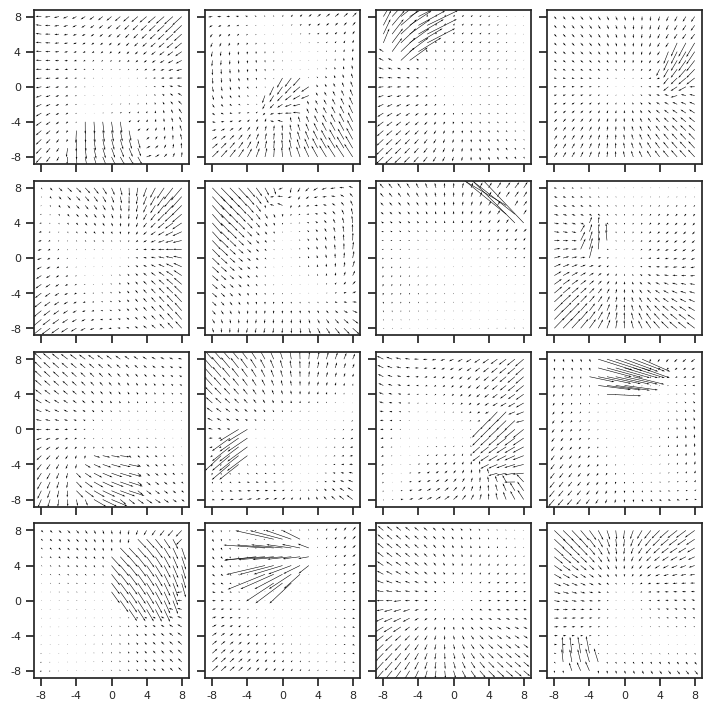

fig/regression

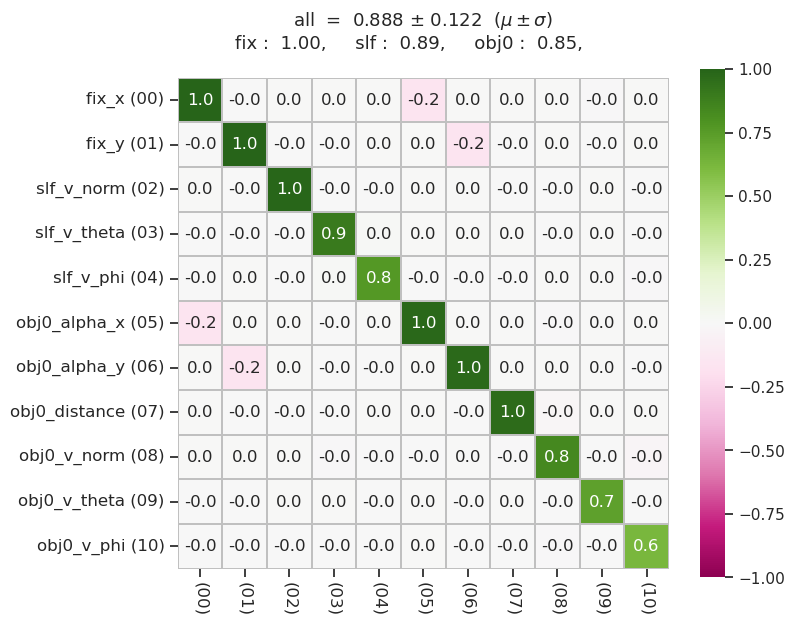

fig/bar

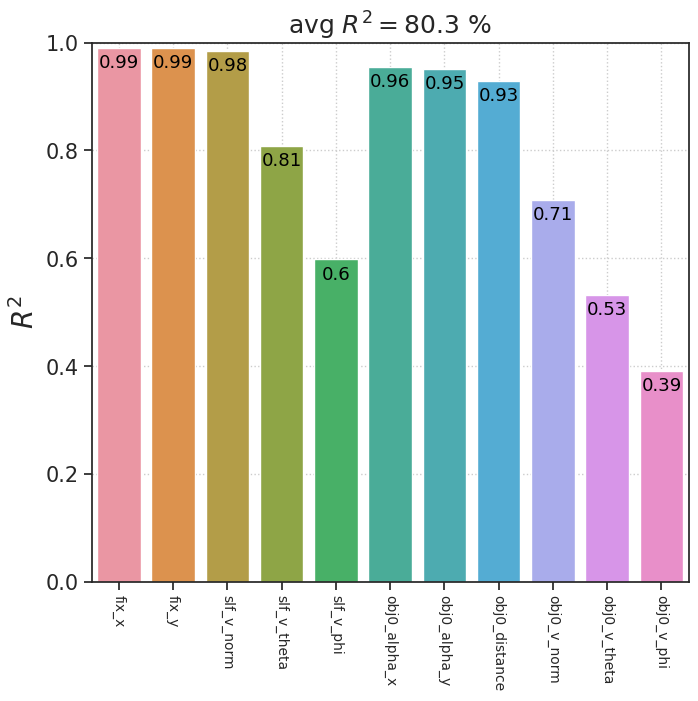

fig/bar_aux

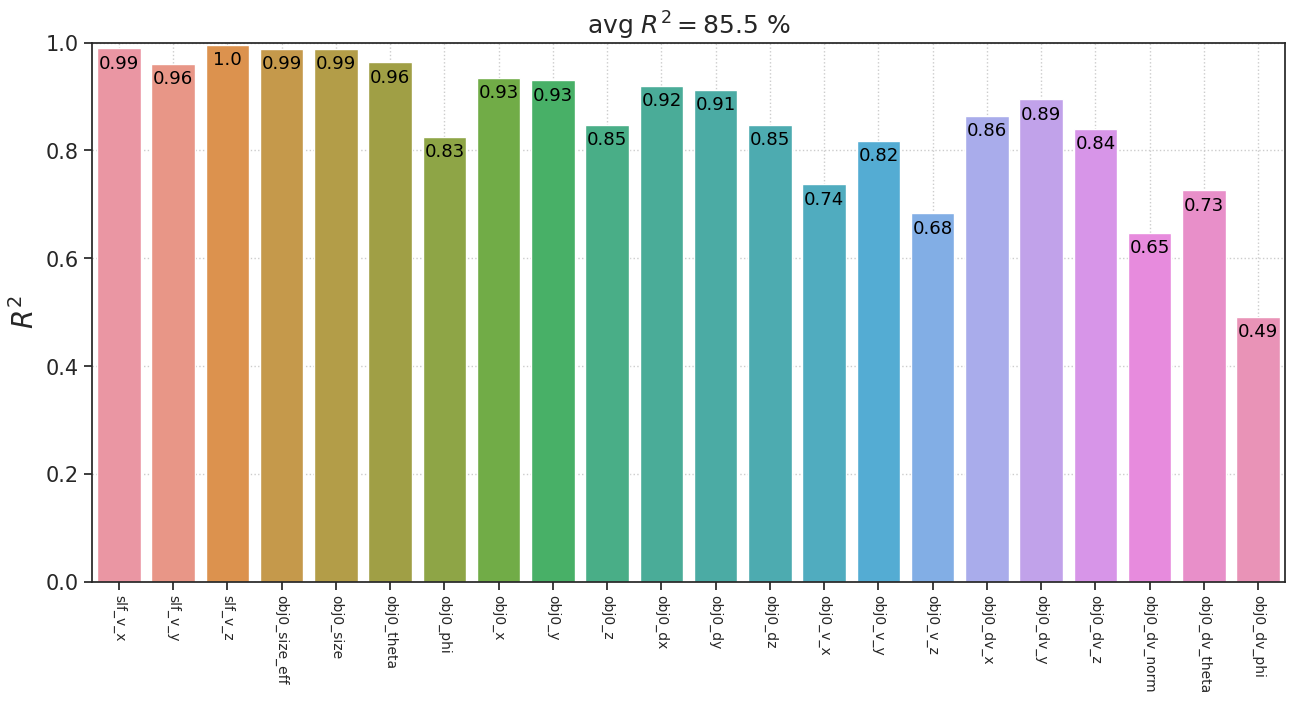

fig/mutual_info

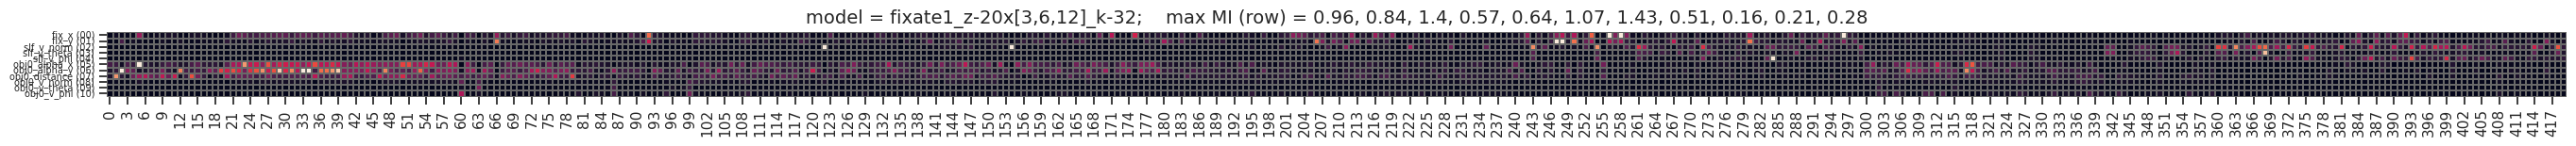

In [10]:
for k, v in data.items():
    if 'fig' not in k:
        continue
    print(k)
    display(v)

## Fix ```res_eps``` issue in json config files

### Warning:

<span style="color:red">Do not run more than once!</span><br>
<span style="color:red">Do not run more than once!</span><br>
<span style="color:red">Do not run more than once!</span>

In [2]:
def insert_str(base_str, new_str, idx):
    return base_str[:idx] + new_str + base_str[idx:]

the_str = '"res_eps": 1.0,\n    '

In [3]:
for p in pathlib.Path(results_dir()).rglob('**/ConfigVAE.json'):
    # load
    with open(str(p), 'r') as f:
        s = f.read()
    # insert
    s = insert_str(s, the_str, s.index('"n_enc_cells"'))
    # write
    with open(str(p), 'w') as f:
        f.write(s)